In [106]:
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='svg'

# 数据压缩 (特征抽取)

- Principal component analysis (PCA) 非监督学习数据压缩
- Linear Discriminant Analysis (LDA) 监督学习降维
- kernel principal component analysis 非线性降维

## PCA 非监督学习数据压缩

1. 标准化$d$维数据集
2. 建立协方差矩阵
3. 将协方差矩阵分解为其特征向量和特征值
4. 选择特征值最大的$k$个特征向量
5. 将上面$k$个特征向量建立成一个投影矩阵$W$
6. 将$d$维输入数据$X$通过投影矩阵$W$映射成$k$维特征子空间

### Total and Explained variance

In [107]:
# 首先我们加载 Wine 数据集
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [108]:
# 然后将数据集分成训练集和测试集,并且进行标准化
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)


In [109]:
# 获取Wine协方差矩阵中的特征对
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print('\nEigenvalues \n{}'.format(eigen_vals))



Eigenvalues 
[4.8923 2.4664 1.4281 1.0123 0.8491 0.6018 0.5225 0.0841 0.3305 0.296
 0.1683 0.2143 0.24  ]


Explained variance 在特征值中的比率指的是
\begin{equation}
\frac{\lambda_j}{\sum_{j=1}^{d}\lambda_j}
\end{equation}

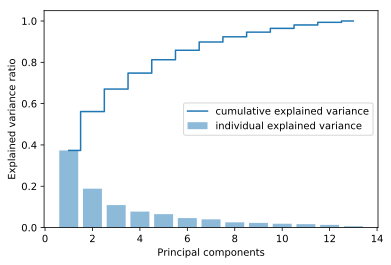

In [110]:
# 下面画出explained variance的累计和的图
import matplotlib.pyplot as plt
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')


### 特征转换

In [111]:
# 对特征值降序排列特征对
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(reverse=True)

In [112]:
# 选择前两个特征
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)


Matrix W:
 [[ 0.1467  0.5042]
 [-0.2422  0.2422]
 [-0.0299  0.287 ]
 [-0.2552 -0.0647]
 [ 0.1208  0.23  ]
 [ 0.3893  0.0936]
 [ 0.4233  0.0109]
 [-0.3063  0.0187]
 [ 0.3057  0.0304]
 [-0.0987  0.5453]
 [ 0.3003 -0.2792]
 [ 0.3682 -0.1744]
 [ 0.2926  0.3632]]


转换样本x到PCA子空间中,得到x'
$$x'=xW$$

In [113]:
X_train_pca = X_train_std @ w

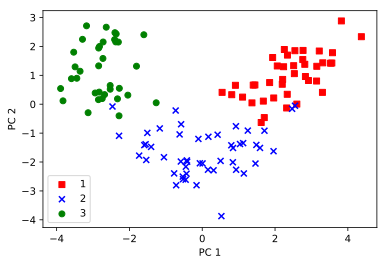

In [114]:
# 画出转换后的Wine数据散点图
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], X_train_pca[y_train == l, 1], c=c, label=l, marker=m)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')


### 通过sklearn使用PCA

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


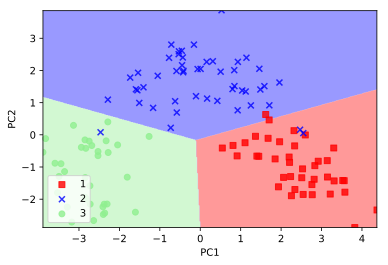

In [115]:
# 调用pca,并且调用plot_decision_region画图
from plotDecisionRegions import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
lr = LogisticRegression()
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)

plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


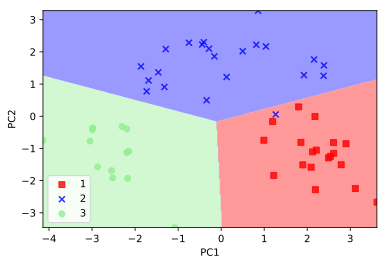

In [116]:
# 在测试集上测试
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='lower left')


In [117]:
# 如果感兴趣不同主成分的explained variance ratios
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_


array([0.3733, 0.1882, 0.109 , 0.0772, 0.0648, 0.0459, 0.0399, 0.0252,
       0.0226, 0.0183, 0.0164, 0.0128, 0.0064])

## 通过LDA进行监督学习数据压缩

1. 标准化$d$维数据集
2. 对于每个类，计算d维平均向量
3. 构造类间散步矩阵$S_B$和类内散布矩阵$S_w$
4. 计算矩阵$S_w^{-1}S_B$特征向量和对应的特征值
5. 选择特征值最大的$k$个特征向量,并构建一个$d \times k$维的转化矩阵$W$;特征向量是矩阵的列
6. 通过矩阵$W$将样本映射到子空间

> 使用LDA的时候,我们假设特征都是标准正态分布的,且彼此独立.同时也假设,各个类的协方差矩阵都是相同的.然而,即使我们在一定程度上不满足以上假设,LDA仍然可以合理地工作在维度降低和分类任务中.

### 计算散布矩阵
\begin{equation}
\boldsymbol{m}_{i}=\left[\begin{array}{c}{\mu_{i, \text {alcohol}}} \\ {\mu_{i, \text {malic} \text {acid}}} \\ {\vdots} \\ {\mu_{i, \text {proline}}}\end{array}\right] \quad i \in\{1,2,3\}
\end{equation}

In [118]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(1, 4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV {}: {}\n'.format(label, mean_vecs[label-1]))


MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



计算类内散布矩阵$S_w$
\begin{equation}
\boldsymbol{S}_{W}=\sum_{i=1}^{c} \boldsymbol{S}_{i}
\end{equation}

每一个独立类$i$的散步矩阵$S_i$
\begin{equation}
S_{i}=\sum_{x \in D_{i}}^{c}\left(x-m_{i}\right)\left(x-m_{i}\right)^{T}
\end{equation}

In [119]:
d = 13
S_w = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row-mv).dot((row-mv).T)
    S_w += class_scatter

print('Within-class scatter matrix: {}x{}'.format(S_w.shape[0], S_w.shape[1]))


Within-class scatter matrix: 13x13


在计算散布矩阵时,我们假设训练集是均匀分布的,但是通过打印类标的个数,我们会发现我们违反了假设

In [120]:
print('Class label distribution: {}'.format(np.bincount(y_train)[1:]))


Class label distribution: [40 49 35]


因此,我们想要在求$S_w$前先对$S_i$进行缩放.__事实上协方差矩阵就是散布矩阵的归一化版本__
\begin{equation}
\Sigma_{i}=\frac{1}{N_{i}} \boldsymbol{S}_{W}=\frac{1}{N_{i}} \sum_{x \in D_{i}}^{c}\left(\boldsymbol{x}-\boldsymbol{m}_{i}\right)\left(\boldsymbol{x}-\boldsymbol{m}_{i}\right)^{T}
\end{equation}

In [121]:
d = 13
S_w = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_w += class_scatter
print('Scaled within-class scatter matrix: {}x{}'.format(S_w.shape[0], S_w.shape[1]))


Scaled within-class scatter matrix: 13x13


下一步我们计算类间散布矩阵$S_B$
\begin{equation}
S_{B}=\sum_{i=1}^{c} N_{i}\left(m_{i}-m\right)\left(m_{i}-m\right)^{T}
\end{equation}

$m$ 是总的平均值

In [122]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i+1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n*(mean_vec-mean_overall).dot((mean_vec-mean_overall).T)
print('Between-class scatter matrix: {}x{}'.format(S_B.shape[0], S_B.shape[1]))


Between-class scatter matrix: 13x13


### 为新的特征子空间选择线性判别式
下面的步骤与PCA很相似,只不过不同于PCA对协方差矩阵的分解,这里是对$S_w^{-1}S_B$矩阵进行分解

In [123]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_w).dot(S_B))

In [124]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

452.72158124497435
156.43636121952323
1.0564670343472254e-13
3.996418537019543e-14
3.409235652909593e-14
2.842170943040401e-14
1.4793035293048285e-14
1.4793035293048285e-14
1.3494134504023504e-14
1.3494134504023504e-14
6.491059855852737e-15
6.491059855852737e-15
2.655812157040677e-15


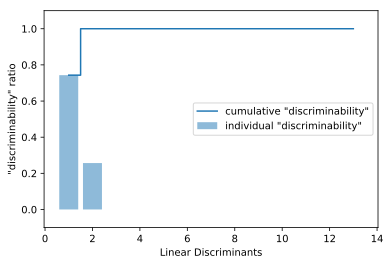

In [125]:
# 下面和PCA一样,我们画出每个类的类判别性的信息
tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted(eigen_vals.real,reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha=0.5, align='center',label='individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid',label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')

由上图可知,前两个线性判别式捕获了数据集中所有有用的信息

In [126]:
# 通过堆叠前两个线性判别的特征向量创建转化矩阵W
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print('Matrix W:\n', w)


Matrix W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


### 将样本映射到新的特征空间
$$X'=XW$$

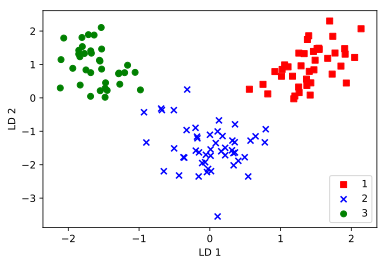

In [127]:
X_train_lda = X_train_std @ w
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0]*(-1), X_train_lda[y_train == l, 1]*(-1), c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')


### 通过scikit-learn使用LDA

In [131]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


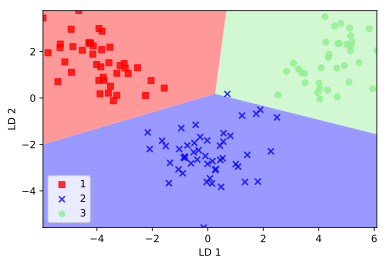

In [132]:
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


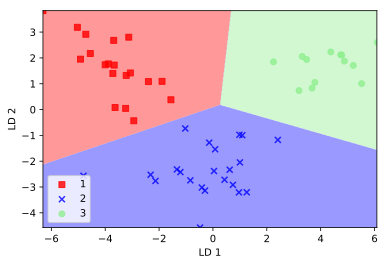

In [133]:
# 测试在测试集上的表现
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')


## 使用核主成分分析进行非线性映射

### 核函数和核技巧
参考书上对应的内容

### 用python实现kernel PCA

In [136]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh
import numpy as np


def rbf_kernel_pca(X, gamma, n_components):
    """
    RBF kernel PCA实现

    parameters
    ----------
    X: {NumPy ndarray}, shape = [n_samples, n_features]

    gamma: float
        调试参数

    n_components: int
        主成分的个数

    Returns
    ------------
    X_pc: {NumPy ndarray}, shape = [n_samples, k_features]
        已经映射好的数据集

    """
    # 在MxN维度的数据集中计算成对的平方欧式距离
    sq_dists = pdist(X, 'sqeuclidean')

    # 将成对的距离转换到一个方阵中
    mat_sq_dists = squareform(sq_dists)

    # 计算对称核矩阵
    K = exp(-gamma*mat_sq_dists)

    # center 核矩阵
    N = K.shape[0]
    one_n = np.ones((N, N))/N
    K = K - one_n@K - K@one_n + one_n@K@one_n

    # 从中心化的核矩阵获取特征对
    eigvals, eigvecs = eigh(K)

    # 选择前K个特征矩阵(已经映射的样本)
    X_pc = np.column_stack((eigvecs[:, -i] for i in range(1, n_components+1)))

    return X_pc


#### 分离半月形状

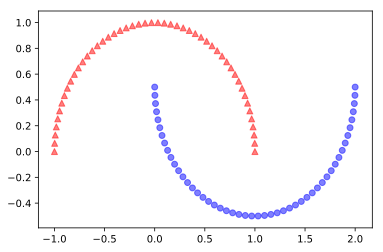

In [137]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)


Text(0.5, 0, 'PC1')

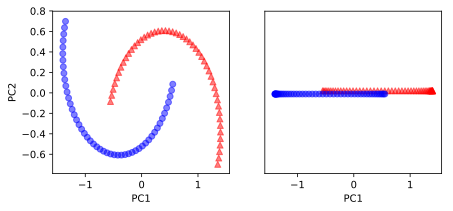

In [138]:
# 上述数据集显然不是线性可分的,这时如果使用标准的PCA,会发生什么呢
from sklearn.decomposition import PCA
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_spca[y == 0, 0], X_spca[y == 0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y == 1, 0], X_spca[y == 1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_spca[y == 0, 0], np.zeros((50, 1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y == 1, 0], np.zeros((50, 1))-0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')


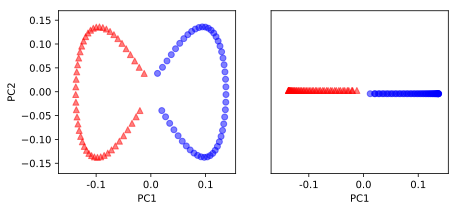

In [139]:
# 现在试试核PCA
from matplotlib.ticker import FormatStrFormatter
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y == 0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y == 1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y == 0, 0], np.zeros((50, 1))+0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((50, 1))-0.02, color='blue', marker='o', alpha=0.5)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax[1].xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
